In [87]:
import re
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import clean_reports
import preprocess_reports



[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


## EDA Data Cleaning

In [88]:
##from sentence_transformers import SentenceTransformer. # will be used for the bert transformer in the future
# dataset location
DATASET = "/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/Data/prospect-data.csv"
print("Dataset saved as DATASET")

# load dataset into dataframe
data = clean_reports.clean(DATASET, raw=True)

data.head()
DATASET=data

#
DATASET2023=data[data['Year'] == 2023]
DATASET2022=data[data['Year'] ==2022]
DATASET2021=data[data['Year'] == 2021]

Dataset saved as DATASET


-----------------
For All Data


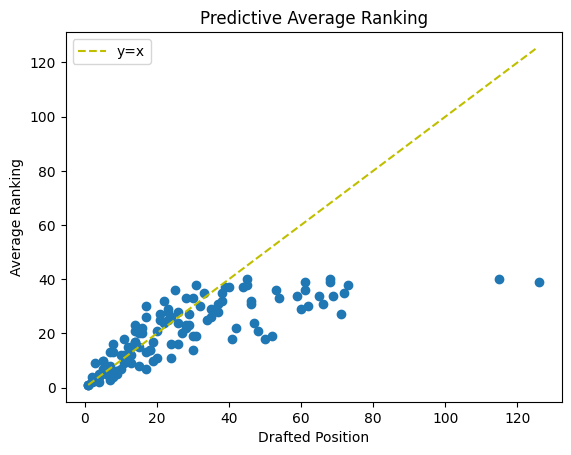

None
-----------------
For 2022


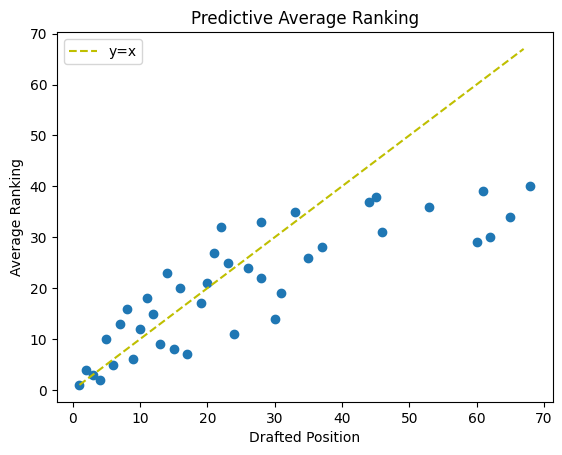

None
-----------------
For 2021


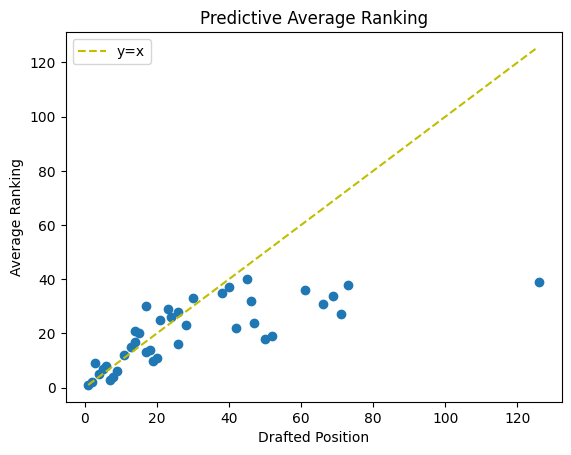

None


In [89]:
def plot_drafted_vs_ranking(data):
    # Create the x-values range from the minimum to the maximum 'Drafted' position
    x = np.arange(data['Drafted'].min(), data['Drafted'].max())     #creates an array of evenly spaced values from min ranked position to max pos
    y = x

    # Scatter plot of 'Drafted' vs 'Average Ranking'
    plt.scatter(data['Drafted'], data['Average Ranking'])

    # Plot a reference line y=x
    plt.plot(x, y, 'y--', label="y=x")
    
    plt.xlabel("Drafted Position")
    plt.ylabel("Average Ranking")
    plt.legend()
    plt.title("Predictive Average Ranking")
    plt.show()

# Now you can call the function with the data you have
print("-----------------")
print("For All Data")
print(plot_drafted_vs_ranking(DATASET))
print("-----------------")
print("For 2022")
print(plot_drafted_vs_ranking(DATASET2022))
print("-----------------")
print("For 2021")
print(plot_drafted_vs_ranking(DATASET2021))

In [90]:
HOCKEY_POSITIONS = {
    'C' : 'Center',
    'D' : 'Defender',
    'RW' : 'Right Wing',
    'LW' : 'Left Wing',
    'G' : 'Goalie'
}

# distribution of player positions
data['Position'].value_counts()

Position
C     134
D     116
RW     78
LW     60
G      14
Name: count, dtype: int64

In [91]:
match = data.columns.str.match('Description')
scouting_reports = data.columns[match]

# Create a deep copy of data
token_count = data.copy(deep=True)

# Define a function to count tokens (words) using split
def count_tokens(text):
    if isinstance(text, str):
        # Split the string by spaces and count the number of words
        return len(text.split())
    else:
        return np.nan

# Apply the function across all scouting report columns
token_count[scouting_reports] = token_count[scouting_reports].applymap(count_tokens)

average_token_count = token_count[scouting_reports].mean().sort_values()

# Display the result
print(average_token_count)


Description - EP Rinkside             79.006329
Description - The Painted Lines      129.969925
Description - ESPN (Chris Peters)    134.960699
Description - Corey Pronman          154.087404
Description - Smaht Scouting         215.127517
Description - Scott Wheeler          230.403756
Description - FCHockey               328.971429
Description - EP Rinkside Part 2     409.613757
dtype: float64


/var/folders/53/kssq81zs06d17_l658v4lbnm0000gn/T/ipykernel_14753/4146433650.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  token_count[scouting_reports] = token_count[scouting_reports].applymap(count_tokens)


In [92]:
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('all-mpnet-base-v2')

/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


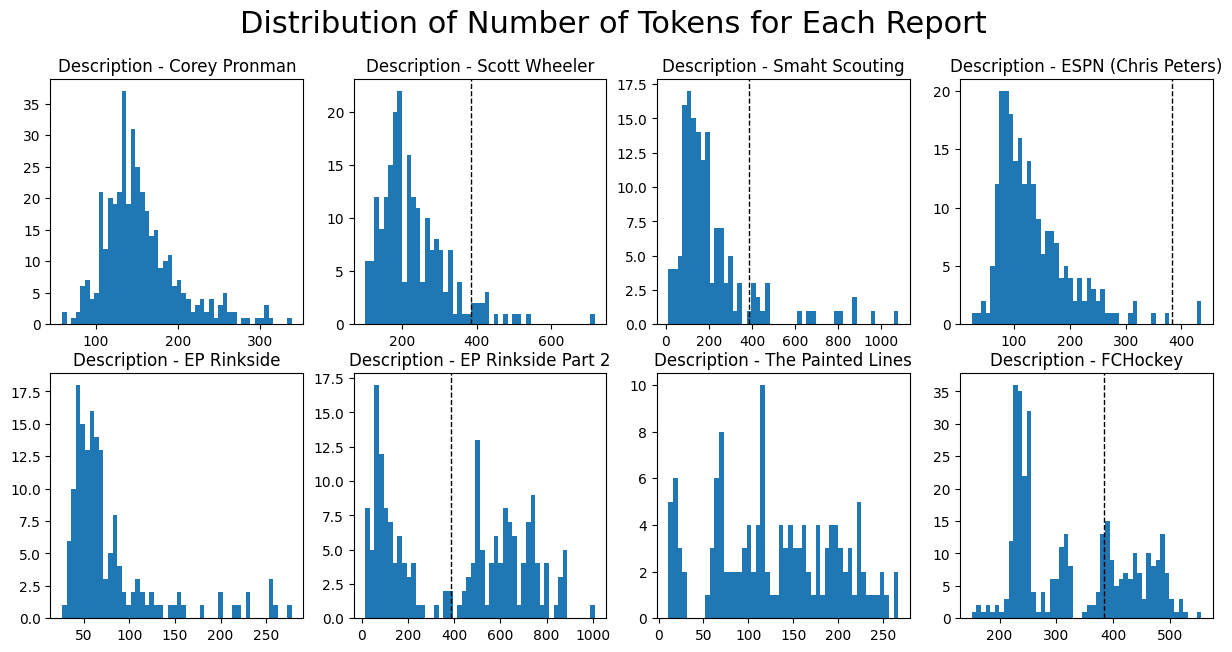

In [93]:
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))

for index, report in enumerate(scouting_reports):
    xx = token_count[report].values  
    i, j = [array[0] for array in np.unravel_index([index], shape=(nrows,ncols))] 
    
    ax[i, j].hist(xx, bins=50) 
    ax[i, j].set_title(report)  
    
    if xx[~np.isnan(xx)].max() > bert_model.max_seq_length:
        ax[i, j].axvline(bert_model.max_seq_length, color='k', linestyle='dashed', linewidth=1)  # Add vertical line

plt.suptitle("Distribution of Number of Tokens for Each Report", fontsize=22)
plt.show()


In [94]:
data = data[data['Team'] != 'SEA'] #seattle is a new team as of 2021 having a 2021 second overall pick

# keep data only to 2014-2022 (predict this year's class at a later time)
data = data[data['Year'] <= 2022]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355 entries, 42 to 401
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               355 non-null    int64  
 1   Position                           355 non-null    object 
 2   Height                             355 non-null    float64
 3   Weight                             355 non-null    float64
 4   Drafted                            355 non-null    float64
 5   Team                               355 non-null    object 
 6   Average Ranking                    115 non-null    float64
 7   Name                               355 non-null    object 
 8   Description - Corey Pronman        342 non-null    object 
 9   Description - Scott Wheeler        166 non-null    object 
 10  Description - Smaht Scouting       104 non-null    object 
 11  Description - ESPN (Chris Peters)  182 non-null    object 
 12

## Bert Transformations


In [107]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer

In [108]:
long_df = preprocessed_df.melt(
    id_vars=['Year', 'Position', 'Height', 'Weight', 'Drafted', 'Team', 'Average Ranking', 'Name'],
    value_vars=scouting_reports.tolist(),
    var_name='reporter',  
    value_name='text'
).dropna(
    subset=['text']
)


bert_embeddings_path = 'data/reports_with_bert_embeddings.csv'

# Check if embeddings already exist
if not os.path.exists(bert_embeddings_patpiph):
    # Load the BERT model
    bert_model = SentenceTransformer('all-mpnet-base-v2')

    # Generate BERT embeddings for the text in 'long_df'
    bert_embeddings = bert_model.encode(long_df['text'].values)
    bert_df = pd.DataFrame(bert_embeddings, columns=[f'bert{i}' for i in range(bert_embeddings.shape[1])])
    long_df = pd.concat([long_df, bert_df], axis=1)
    long_df.to_csv(bert_embeddings_path, index=False)
    print("New File Was created")
else:
    # Load the DataFrame with BERT embeddings
    long_df = pd.read_csv(bert_embeddings_path)
    bert_columns = [col for col in long_df.columns if col.startswith('bert')]
    print("The BERT Embedding file was overriden")

/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ImportError: cannot import name 'CSVFormatter' from 'pandas.io.formats.csvs' (/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/.venv/lib/python3.12/site-packages/pandas/io/formats/csvs.py)